In [42]:
# Importing the necessary packages
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets   as torch_datasets
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torch.utils.data   import Dataset
from   torchsummary       import summary
from   tqdm  import tqdm

In [64]:
# ----------- Creating a Train and Test Dataset ----------------

# Transformation to be applied to the images before giving as input to model
transformations = transforms.Compose([transforms.ToTensor()
                                    , transforms.Normalize((0.1751,), (0.3332,))])# The mean and standard deviation for EMNIST data (balanced)

# Creating a training dataset from EMNIST Balanced:  131,600 characters. 47 balanced classes.
train_set = torch_datasets.EMNIST('../data_emnist', split='byclass'
                          , train=True, download=True
                          , transform = transformations)

test_set  = torch_datasets.EMNIST('../data_emnist', split='byclass'
                          , train=False, download=True
                          , transform = transformations)

In [65]:
'''
    This block is run for a batch_size = len(train_set), to get mean and std of the training images
    BEFORE normalization is applied to the dataset, after .ToTensor() method squishes 0-255 range of pixel
    values between 0-1
'''
# for images,target in train_loader:
#     mean_images = (images).mean()
#     std_images  = (images).std()
# print("Mean of images = {}".format(mean_images))   # Mean =  0.17510417103767395
# print("Standard deviation of images = {}".format(std_images)) # std = 0.3332371413707733

'\n    This block is run for a batch_size = len(train_set), to get mean and std of the training images\n    BEFORE normalization is applied to the dataset, after .ToTensor() method squishes 0-255 range of pixel\n    values between 0-1\n'

In [66]:
'''
    This block is to assert whether both training and test sets have the same number/type of 
    classes (with the same labelling) for classification, and assign the number to a variable 
    'num_classes' which will be equal to the number of kernel that will be used later in the 
    final convolution layer, just before the GlobalAveragePooling (gap) layer in the NeuralNetwork.
 '''
classes_in_train = train_set.targets.unique().numpy()
classes_in_test  = test_set.targets.unique().numpy()
assert np.isin(classes_in_test,classes_in_train).all()

num_classes = len(train_set.targets.unique().numpy())
print(f'Number of classes: {num_classes}')

Number of classes: 62


In [67]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        '''RF formula: 
           RF[n] = RF[n-1] + (kernel_size - 1) * j[n-1], where:- 
           RF[k] is the receptive field of k'th layer and j[k] is the jump (cumulative stride)
           j[n] = j[n-1] * stride[n-1]
           j[1] = 1 and RF[1]=1
        '''
        # Input layer (image): | RF: 1  | j[0] = 1
        self.conv1 = nn.Conv2d(1 , 10, 3, padding=1) # Input: 28x28x1  | Output: 28x28x10 | RF:3  | j[1] = j[2]*1 = 1
        self.conv2 = nn.Conv2d(10, 10, 3, padding=1) # Input: 28x28x10 | Output: 28x28x10 | RF:5  | j[2] = j[3]*1 = 1
        self.pool1 = nn.MaxPool2d(2, 2)              # Input: 28x28x10 | Output: 14x14x10 | RF:6  | j[3] = j[4]*2 = 2
        '''
        For self.pool1 (layer[3]): j[3] = j[2]*stride = 1 * 2 = 2
        '''
        self.conv3 = nn.Conv2d(10, 20, 3, padding=1) # Input: 14x14x10 | Output: 14x14x20 | RF:10  | j[4] = j[3]*1 = 2
        self.conv4 = nn.Conv2d(20, 20, 3, padding=1) # Input: 14x14x20 | Output: 14x14x20 | RF:14  | j[5] = j[4]*1 = 2
        self.pool2 = nn.MaxPool2d(2, 2)              # Input: 14x14x20 | Output: 7x7x20   | RF:16  | j[6] = j[4]*2 = 4
        '''
        For self.pool2 (layer[6]): j[6] = j[5]*stride = 2 * 2 = 4
        '''
        self.conv5 = nn.Conv2d(20, 30, 3)            # Input: 7x7x20   | Output: 5x5x30   | RF:24  | j[7] = j[6]*1 = 4
        self.conv6 = nn.Conv2d(30, num_classes, 3)   # Input: 5x5x30   | Output: 3x3x62   | RF:32  | j[8] = j[6]*1 = 4
        self.gap   = nn.AvgPool2d(3)                 # Input: 3x3x62   | Output: 1x1x62   | RF:40  | j[8] = j[6]*3 = 12

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.conv6(F.relu(self.conv5(x)))
        x = self.gap(x)
        x = x.view(-1, num_classes)
        return F.log_softmax(x,dim=1)

In [68]:
use_cuda = torch.cuda.is_available()                   # Checks if Cuda is available, and returns True if yes
device   = torch.device("cuda" if use_cuda else "cpu") # Selects whether to load and train on GPU or CPU
model    = NeuralNet().to(device)                      # Loads the model weights on the gpu or cpu
summary(model, input_size=(1, 28, 28))                 # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
            Conv2d-2           [-1, 10, 28, 28]             910
         MaxPool2d-3           [-1, 10, 14, 14]               0
            Conv2d-4           [-1, 20, 14, 14]           1,820
            Conv2d-5           [-1, 20, 14, 14]           3,620
         MaxPool2d-6             [-1, 20, 7, 7]               0
            Conv2d-7             [-1, 30, 5, 5]           5,430
            Conv2d-8             [-1, 62, 3, 3]          16,802
         AvgPool2d-9             [-1, 62, 1, 1]               0
Total params: 28,682
Trainable params: 28,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.11
Estimated Total Size (MB): 0.32
---------------------------------------------

In [69]:
# Creating data loaders to load samples from dataset (train or test)
torch.manual_seed(2020)   # Set Randomization seed for shuffle
batch_size   = 2048        # Set Batch size for each sample batch pulled by loaders
kwargs       = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size = batch_size, shuffle=True, **kwargs)

In [70]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader,leave=False)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Sets the gradients of all optimized torch.Tensors to zero. 
        # It’s important to call optimizer.zero_grad() before loss.backward(), otherwise gradients will be accumulated from multiple passes.
        output = model(data)                  # The feed forward pass for generating output from data
        loss   = F.nll_loss(output, target)   # Calculates the negative log likelihood loss for the given sets of output to predicted targets
        loss.backward()         # Calculates the d(loss)/dx for each parameter x, which are accumulated into x.grad
        optimizer.step()        # optimizer.step() multiples the learing rate with the x.grad and updates each model parameter
        string_name = 'Epoch={} | Batch_id={} | Loss={:.6f}'.format(epoch,batch_idx,loss.item())
        pbar.set_description(desc=string_name) # Updates the description at every timestep while showing the progress bar

    # Getting Training Accuracy
    model.eval()
    total_train_loss = 0
    correct_train = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption 
    # by making sure tensor.Backward() is not called
    with torch.no_grad():
        for data, target in train_loader:
            data, target   = data.to(device), target.to(device)
            output         = model(data)
            total_train_loss += F.nll_loss(output, target, reduction='sum').item()  # sums up the loss for all samples in a batch
            pred           = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_train += pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target

    train_loss     = total_train_loss/len(train_loader.dataset)
    train_accuracy = 100. * (correct_train / len(train_loader.dataset))
    print('\nEpoch:{}\nTrain Set: Mean loss: {:.4f}, Train Accuracy: {}/{} ({:.1f}%)'.format(epoch,
        train_loss, correct_train, len(train_loader.dataset),train_accuracy))
    return train_loss,train_accuracy
    
def test(model, device, test_loader):
    model.eval()
    total_test_loss,correct_test = 0,0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption 
    # by making sure tensor.Backward() is not called
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            total_test_loss += F.nll_loss(output, target, reduction='sum').item()  # sums up the loss for all samples in a batch
            pred         = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_test+= pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target

    test_loss = total_test_loss/len(test_loader.dataset)
    test_accuracy = 100. * (correct_test / len(test_loader.dataset))
    print('\nTest Set : Mean loss: {:.4f}, Test Accuracy : {}/{} ({:.1f}%)\n'.format(
        test_loss, correct_test, len(test_loader.dataset),test_accuracy))
    return test_loss,test_accuracy

In [ ]:
LR = 0.005
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)  # Applies mini-batch gradient descent for training

num_epochs   = 20
update_lr_ep = int(num_epochs*0.5)
'''
    update_lr_ep: epoch at which the Learning rate will be updated
   
    We will be reducing the learning rate by a factor of 10 after every (0.5*num_epochs = 10 epochs).
    (epoch starts from 0). A total reduction factor of 1000 in learning rate after 15 epochs. 
    This is so that the training loss does not plateau, which was seen when a fixed learning rate of 0.01 was used.
'''
train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []
for epoch in range(0, num_epochs):

    if ((epoch + 1) % update_lr_ep) == 0:
        old_learn_rate = optimizer.param_groups[0]['lr']
        new_learn_rate = optimizer.param_groups[0]['lr']/10
        optimizer.param_groups[0]['lr'] = new_learn_rate
        print("\n--------------------------------------------------------")
        print("Learning rate updated from {} to {} at epoch {}!".format(old_learn_rate,new_learn_rate,epoch))
        print("--------------------------------------------------------\n")

    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    # A folder has been created to save the trained models at each epoch
    model_path = '../data_emnist/trained_models/emnist_classification_model_epoch_'+str(epoch)+'_batchsize_'+str(batch_size)+'_lr_'+str(LR)
    torch.save(model.state_dict(), model_path)

    test_loss,test_acc   = test(model, device, test_loader)

    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)

# model.load_state_dict(torch.load(model_path), strict=False)
# For loading the model saved at a particular epoch

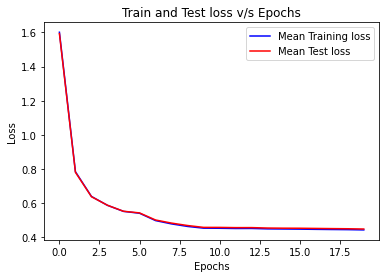

<Figure size 432x288 with 0 Axes>

In [84]:
epochs = range(0,num_epochs)
plt.plot(epochs, train_loss_vals, 'b', label='Mean Training loss')
plt.plot(epochs, test_loss_vals , 'r', label='Mean Test loss')
plt.title('Train and Test loss v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('../data_emnist/loss.png')

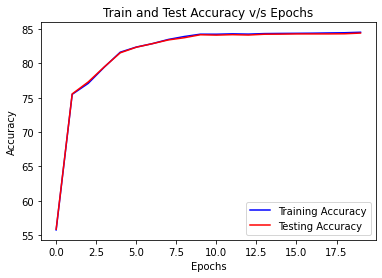

<Figure size 432x288 with 0 Axes>

In [86]:
plt.plot(epochs, train_acc_vals, 'b', label='Training Accuracy')
plt.plot(epochs, test_acc_vals, 'r', label='Testing Accuracy')
plt.title('Train and Test Accuracy v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('../data_emnist/accuracy.jpg')